# Building a Handwritten Digits Classifier

### Goals

* Explore why image classification is a hard task
* Observe the limitations of traditional machine learning models for image classification
* Train, test, and improve a few different deep neural networks for image classification
* Build models that can classify handwritten digits.

### Some history
Before the year 2000, institutions like the United States Post Office used handwriting recognition software to read addresses, zip codes, and more. One of their approaches, which consists of pre-processing handwritten images then feeding to a neural network model is detailed in **[this paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.852.5499&rep=rep1&type=pdf)**.

`Scikit-learn` contains a **[number of datasets](https://scikit-learn.org/stable/datasets/index.html)** pre-loaded with the library, within the namespace of sklearn.datasets. The `load_digits()` function returns a copy of the **[hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)** from UCI.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [3]:
labels = pd.Series(digits['target'])

In [4]:
data = pd.DataFrame(digits['data'])
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, I need to reshape the image back to its original dimensions (8 x 8 pixels).

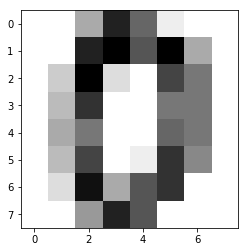

In [5]:
first_img = data.iloc[0]
np_image = first_img.values
np_image = np_image.reshape(8,8)

plt.imshow(np_image, cmap='gray_r')

Now I'll visualize some of the images in the dataset.
I'll Generate a scatter plot grid, with 2 rows and 4 columns.

* In the first row:
    I'll display the images corresponding to rows 0, 100, 200, and 300.
* In the second row:
    I'll display the images corresponding to rows 1000, 1100, 1200, and 1300.

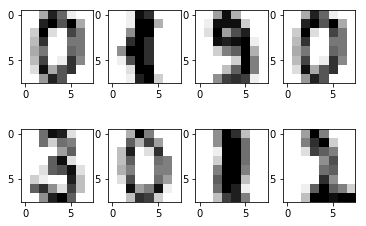

In [6]:
fig, axmap = plt.subplots(2,4)

# trying to use list comprehension or lambda to optimize
# ax = lambda x: axmap[x, x+1].imshow(data.iloc[x+100].values.reshape(8,8), cmap='gray_r')

axmap[0, 0].imshow(data.iloc[0].values.reshape(8,8), cmap='gray_r')
axmap[0, 1].imshow(data.iloc[99].values.reshape(8,8), cmap='gray_r')
axmap[0, 2].imshow(data.iloc[199].values.reshape(8,8), cmap='gray_r')
axmap[0, 3].imshow(data.iloc[0].values.reshape(8,8), cmap='gray_r')

axmap[1, 0].imshow(data.iloc[999].values.reshape(8,8), cmap='gray_r')
axmap[1, 1].imshow(data.iloc[1099].values.reshape(8,8), cmap='gray_r')
axmap[1, 2].imshow(data.iloc[1199].values.reshape(8,8), cmap='gray_r')
axmap[1, 3].imshow(data.iloc[1299].values.reshape(8,8), cmap='gray_r')

## K-Nearest Neighbors Model

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm makes no such assumption. This allows them to capture nonlinearity in the data.

`K-nearest neighbors (KNN)` don't have a specific model representation (hence why it's referred to as an algorithm and not a model).

KNN compares every unseen observation in the test set to all (or many, as some implementations constrain the search space) training observations to look for similar (or the "nearest") observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# 50/50 train vs. test validation
def train_knn(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == 
                           train_test_df["correct_label"])/len(train_test_df)
    return overall_accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state= 2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_knn(k, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

knn_one_accuracies = cross_validate(1)
np.mean(knn_one_accuracies)

0.9677233358079684

Text(0,0.5,'K accuracy')

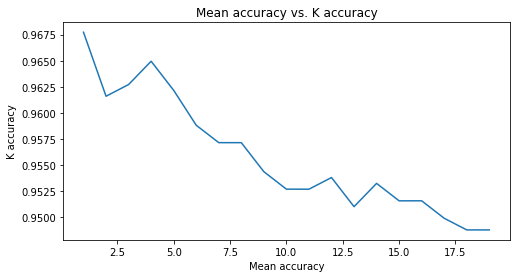

In [8]:
k_values = list(range(1,20))
k_overall_accuracies = []

for k in k_values:
    k_accuracies = cross_validate(k)
    k_mean = np.mean(k_accuracies)
    k_overall_accuracies.append(k_mean)


plt.figure(figsize=(8,4))
plt.title("Mean accuracy vs. K accuracy")
plt.plot(k_values, k_overall_accuracies)
plt.xlabel("Mean accuracy")
plt.ylabel("K accuracy")

There are a few downsides to using k-nearest neighbors:

* High memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
* There's no model representation to debug and explore

So now I'll try a neural network with a single hidden layer.

## Neural Network: One Hidden Layer

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

# 50% Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

C:\Users\elish\Anaconda3\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


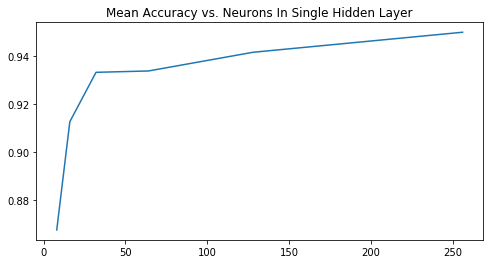

In [10]:
nn_one_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]
nn_one_accuracies = []

for n in nn_one_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_one_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Single Hidden Layer")

x = [i[0] for i in nn_one_neurons]
plt.plot(x, nn_one_accuracies)

## Summary:
It appears adding more neurons to the single hidden layer helped massively improved simple accuracy from approximately `86%` to approximately `94%`. Simple accuracy computes the number of correct classifications the model made, but doesn't tell us anything about false or true positives or false or true negatives.

Given that k-nearest neighbors achieved approximately `96%` accuracy, there doesn't seem to be any advantages to using a single hidden layer neural network for this problem.

## Neural Network: Two Hidden Layers

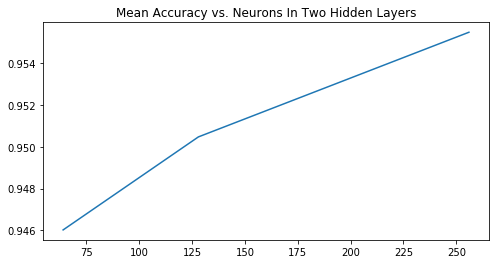

In [11]:
nn_two_neurons = [
    (64,64),
    (128, 128),
    (256, 256)
]
nn_two_accuracies = []

for n in nn_two_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_two_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layers")

x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracies)

In [12]:
nn_two_accuracies

[0.9460207869339272, 0.9504689433308586, 0.9554738926008415]

### Summary
Using 2 hidden layers improved our simple accuracy to 95%. While I'd traditionally be worried about overfitting, using 4-fold cross validation also gives me a bit more assurance that the model is generalizing to achieve the extra 1% in simple accuracy over the single hidden layer networks we tried earlier.

## Neural Network: Three Hidden Layers

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# 50% Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate_six(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state=2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

C:\Users\elish\Anaconda3\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


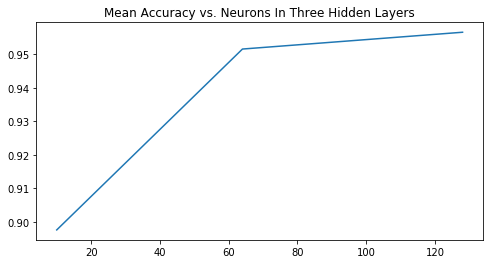

In [14]:
nn_three_neurons = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracies = cross_validate_six(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies)

In [15]:
nn_three_accuracies

[0.8976347082868822, 0.9515904868078783, 0.9566016350798959]

## Neural Network: Four Hidden Layers

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# 50% Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate_six(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 8, random_state=2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

C:\Users\elish\Anaconda3\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


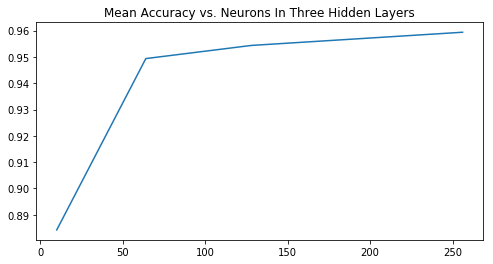

In [17]:
nn_four_neurons = [
    (10, 10, 10, 10),
    (64, 64, 64, 64),
    (128, 128, 128, 128),
    (256, 256, 256, 256)
]

nn_four_accuracies = []

for n in nn_four_neurons:
    nn_accuracies = cross_validate_six(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_four_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_four_neurons]
plt.plot(x, nn_four_accuracies)

In [18]:
nn_four_accuracies

[0.8842584325396825,
 0.9493576388888889,
 0.9543526785714285,
 0.9593625992063493]

## Neural Network: Five Hidden Layers

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# 50% Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate_six(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 8, random_state=2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

C:\Users\elish\Anaconda3\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


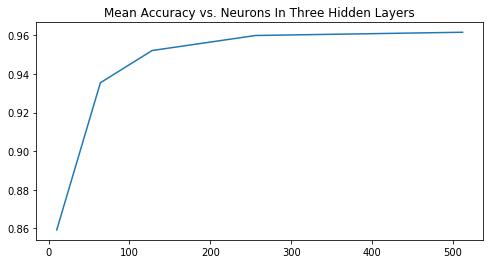

In [20]:
nn_five_neurons = [
    (10, 10, 10, 10, 10),
    (64, 64, 64, 64, 64),
    (128, 128, 128, 128, 128),
    (256, 256, 256, 256, 256),
    (512, 512, 512, 512, 512)
]

nn_five_accuracies = []

for n in nn_five_neurons:
    nn_accuracies = cross_validate_six(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_five_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_five_neurons]
plt.plot(x, nn_five_accuracies)

In [21]:
nn_five_accuracies

[0.8592261904761905,
 0.9354439484126984,
 0.9521329365079365,
 0.9599131944444445,
 0.9615972222222222]

## Conclusion
Using 5 hidden layers improved the predictive accuracy of the handwritten digits classifier to `96%` , even with 8-fold cross validation. This seems support the research literature about deep neural networks for computer vision that having more layers and more neurons tends to improve the network's performance.